In [488]:
%matplotlib inline
# these two lines allow you to control the figure size
# %pylab inline
# pylab.rcParams['figure.figsize'] = (2.0, 2.0)
import numpy as np
import pandas
from IPython.display import Image as display
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import scipy.misc
import scipy.io
from scipy.stats import multivariate_normal
import seaborn
DOT = np.dot
T = np.transpose
import pickle
import math
import random 
import  scipy.stats as stat
from sklearn import linear_model
import sys

In [501]:
# Set the number of polygons that we're going to have
N_CLUSTERS = 11
COV = 5
COV_2D = [[COV, 0], [0, COV]]
MEAN = 0

MIN_DIM = -250
MAX_DIM = 250

colors = ["red", "blue", "green", "orange", "purple", "pink", "black", 
          "lightblue", "lightgreen","navy", "gray"]

def chunks(max_x, n):
    skew = max_x * 2
    part = skew/float(n) 
    parts = []
    i = 0
    while i < skew:
        parts.append((i - max_x, min(skew, i+part) - max_x))
        i += part
    return parts

def dist_slopes(max_x, num_slopes):
    chunk_list = chunks(max_x, num_slopes)
    #print chunk_list
    slope_list = []
    for a,b in chunk_list:
        slope_list.append(random.uniform(a,b))
    return slope_list  

def getSkew(data, weights, scaler=20):
    incr = np.rint(weights * scaler)
    
#     print "\n\nweights:", weights
#     print "incr:", incr
    
    skew = []
    for i in xrange(data.shape[0]):
        freq = int(incr[i])
        if freq < 1:
            freq = 1
        for j in xrange(freq):
            skew.append(data[i,:])
    skew = np.array(skew)   
    return skew

def getPointsInCluster(cluster_weights, t = 0.5):
    cluster = []
    for i in xrange(cluster_weights.shape[0]):
        point = data[i, :]
        weight = cluster_weights[i]
        if weight > t:
            cluster.append(point)
    return np.asarray(cluster)

def cov_to_pts( cov ):
    circ = np.linspace( 0, 2*np.pi, 100 )
    sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
    [u,s,v] = np.linalg.svd( cov )
    pmat = u*2.447*np.sqrt(s) # 95% confidence
    return np.dot(  pmat, sf )

def plot_it(ax, c_w, row, col, data, slopes, y_inters, title):
    clusters = []
    
    for n in xrange(N_CLUSTERS):  
        clusters.append( getPointsInCluster(c_w[:,n:n+1], t = 0.5))
        #plot line
        buff = 0
        xs, ys = getLine(slopes[n], y_inters[n], min_x = np.min(data[:,0])-buff, max_x =np.max(data[:,0]+buff))
        ax[row,col].plot(xs, ys, c=colors[n])
        if len(clusters[n] > 0):
            ax[row,col].scatter(clusters[n][:,0], clusters[n][:,1], color=colors[n],marker='x',
                    label='cluster ' + str(n + 1))
        ax[row,col].set_ylim([MIN_DIM,MAX_DIM])
        ax[row,col].set_xlim([MIN_DIM,MAX_DIM])

#     ax[row,col].scatter(data[:,0], data[:,1], color='purple', marker='x',
#                 label='data points')


    ax[row,col].title.set_text(title)
    
def eu_dist(x,y):   
    return np.sqrt(np.sum((x-y)**2))

def getmus(N_CLUSTERS):
    r = 125
    points = []
    for index in range(N_CLUSTERS):
        points.append([r*math.cos((index*2*math.pi)/N_CLUSTERS + r),r*math.sin((index*2*math.pi)/N_CLUSTERS + r)])
    return points

def get_parameters(N_CLUSTERS, data_ys):
    y_inters = []
    slope_list = []
    ys = np.unique(data_ys)
    for i in xrange(N_CLUSTERS):
        chosen_y_index = random.uniform(0, ys.shape[0])
        y_inters.append(ys[chosen_y_index])
        slope_list.append(random.uniform(-10, 10))
    return dist_slopes(10, N_CLUSTERS) , y_inters

def getLineMu(data_pt, slope, y_inter, min_x = MIN_DIM, max_x = MAX_DIM):
    # y = mx + b
    #create line segment 
    line_seg = getLineSeg(slope, y_inter, min_x, max_x)
    return nearestPoint(line_seg, data_pt)
    
def nearestPoint(line_seg, data_pt):
    x1, y1 = line_seg[0]
    x2, y2 = line_seg[1]
    x3, y3 = data_pt
    
    k = ((y2-y1) * (x3-x1) - (x2-x1) * (y3-y1)) / float((y2-y1)**2 + (x2-x1)**2)
    x4 = x3 - k * (y2-y1)
    y4 = y3 + k * (x2-x1)
    
    nearest_pt = [x4, y4]
    return nearest_pt## Expectation

def getLineSeg(slope, y_inter, min_x = MIN_DIM, max_x = MAX_DIM):
    min_y = slope*min_x + y_inter
    max_y = slope*max_x + y_inter
    line_seg = [[min_x, min_y],[max_x, max_y]]
    return line_seg

def getLine(slope, y_inter, min_x = MIN_DIM, max_x = MAX_DIM):
    xs = np.arange(min_x, max_x)
    ys = []
    for x in xs:
        ys.append(x*slope + y_inter)
    return xs, ys
        
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def getSlope(pt1, pt2):
    x1, y1 = pt1
    x2, y2 = pt2
    
    slope = (y2 - y1) / (float(x2 - x1) + sys.float_info.epsilon)
    return slope

def getYInter(pt1, pt2):
    x1, y1 = pt1
    x2, y2 = pt2
    
    m = getSlope(pt1, pt2)
    b=y1-m*x1
    return b



/Users/Iris/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:100: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


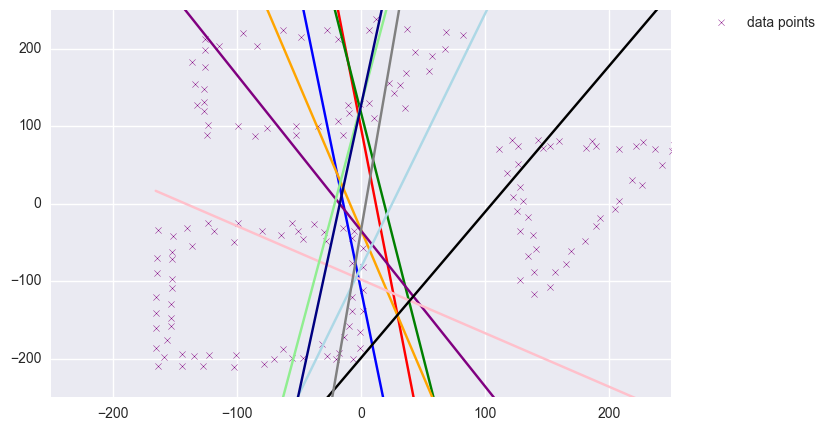

In [502]:
# LOAD DATA
with open("points_map_1.dat") as f:
    data = pickle.load(f)

data = np.array(data)
data = np.reshape(data,(2, data.shape[1])).T


# with open("points_tri_2.dat") as f:
#     data = pickle.load(f)

# data = np.array(data)
# data = np.reshape(data,(2, data.shape[1])).T
# Number of data points
POINTS = data.shape[0]

#mean center the data
data = data - data.mean(axis = 0)

#mus (N_CLUSTERS, 2)
mus = np.asarray(getmus(N_CLUSTERS)) 

#return arrays for N_Clusters of each parameter
slopes, y_inters = get_parameters(N_CLUSTERS, data[:,1:2]) 

#Perfect all around
# slopes = [.7,-.7,.01]
# y_inters = [-40,-40,30]

# slopes = [2,-2,.01]
# y_inters = [10,70,-35]

# slopes = [2,-.4,.1]
# y_inters = [-20,-40, 30]

# slopes = [2,-.8,.1]
# y_inters = [-30,-40, 30]

# slopes = [10, 10, .1, .1]
# y_inters = [-1500, 1500, 210, -210]


# data_ys = data[:,1:2]
# print data_ys.shape
# print data_ys[0][0]

#the Gaussian mixing weights
my_randoms = random.sample(xrange(100), N_CLUSTERS)
mws = [float(my_randoms[i])/sum(my_randoms) for i in xrange(N_CLUSTERS)]  # called alpha in the slides

#create covariance matrixes
n = 600
covs = list()
for p in xrange(N_CLUSTERS):
    x=np.random.normal(size=(2,2))
    y=np.random.normal(size=(2,2))
    z = np.vstack((x, y))
    covs.append(n*np.cov(z.T))
covs = np.asarray(covs)

 
###################################################################################
############################## PLOTTING INITIAL PARAMETERS ########################

plt.scatter(data[:,0], data[:,1], color='purple', marker='x',
            label='data points')

for n in xrange(N_CLUSTERS):
    #plot line
    buff = 0
    xs, ys = getLine(slopes[n], y_inters[n], min_x = np.min(data[:,0])-buff, max_x =np.max(data[:,0]+buff))
    plt.plot(xs, ys,c=colors[n])
    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([MIN_DIM,MAX_DIM])
plt.xlim([MIN_DIM,MAX_DIM])
plt.show()

In [503]:
#Compute the responsibilities (Eq. 11.27)
def Expectation(covs, mws):
    cluster = []
    sum_to_norm = np.zeros((POINTS,1))
    for n in xrange(N_CLUSTERS):
        cluster_n = np.zeros((POINTS,1))
        for d in xrange(POINTS):
            data_pt = data[d,:] # 1 x 2 
            #Flattened Gaussian
            line_mu = getLineMu(data_pt, slopes[n], y_inters[n]) #returns a tuple (x, y)
            dist = eu_dist(np.array(data_pt),np.array(line_mu))
            closeness = gaussian(dist, MEAN, COV)
            cluster_n[d] = closeness
        cluster_n *= mws[n]
        cluster.append(cluster_n)
        sum_to_norm += cluster_n
        
    
    for n in xrange(N_CLUSTERS):
        cluster[n] = cluster[n] / sum_to_norm
        
    clusters = np.asarray(cluster).T
    clusters = clusters.reshape((POINTS,N_CLUSTERS))
    
    return clusters
    
        

In [504]:
def Maximization(cluster_w):
    #print "Cluster, ", cluster_w.shape #(113, N_CLUSTERS)
    # combine weights into 1 matrix
    cluster_probs = np.zeros((N_CLUSTERS, POINTS))
    for n in xrange(N_CLUSTERS):
        cluster_probs[n] = cluster_w[:,n]
    cluster_probs = np.transpose(cluster_probs)

    # do the argmax to find out which label is assigned to data point
    # (POINTS, n) composed of 0s and 1s, which cluster it belongs most to
    assigned_labels = cluster_probs.argmax(1)
    assigned_labels = assigned_labels.reshape((POINTS,1))
    
    # Get points for each cluster 
    cluster_points = []
    for n in xrange(N_CLUSTERS):
        cluster_points.append( data[np.where(assigned_labels == n)[0]])
    
    new_mws = []
    new_mus = []
    new_covs = list()
    for n in xrange(N_CLUSTERS):
        cluster_N = np.sum(cluster_w[:,n]) #sum all the weights within a cluster
        # New mws ======================
        new_mws.append(cluster_N /float(data.shape[0]))
        
        #skew points
        weighted_pts_n = getSkew(data, cluster_w[:,n])
        
        #Running RANSAC on weighted points on line
        model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
        model_ransac.fit(weighted_pts_n[:,0:1], weighted_pts_n[:,1:2])
        
        #Get unique existing(weighted) x's
        all_xs = weighted_pts_n[:,0:1]
        line_X = np.unique(all_xs)
        
        line_y_ransac = model_ransac.predict(line_X[:, np.newaxis])
        line_y_ransac = line_y_ransac[:,0]
    
        #update line parameters ====================
        
        pt1, pt2 = [line_X[0], line_y_ransac[0]],[line_X[1], line_y_ransac[1]]
        new_slope = model_ransac.estimator_.coef_[0][0]
        b = getYInter(pt1, pt2)
        new_y_inter = b
        # ins = np.sum(inlier_mask)
        # outs = np.sum(outlier_mask )
        # ratio = ins/float(outs)
        slopes[n] = new_slope
        y_inters[n] = new_y_inter
        
    return new_mws, cluster_points

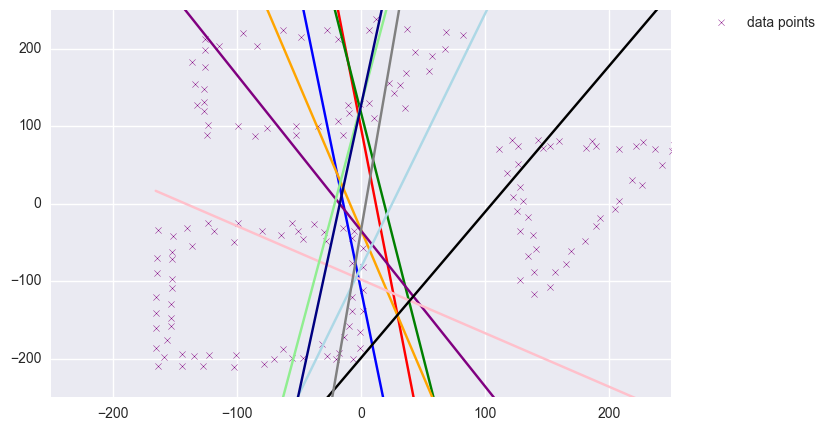

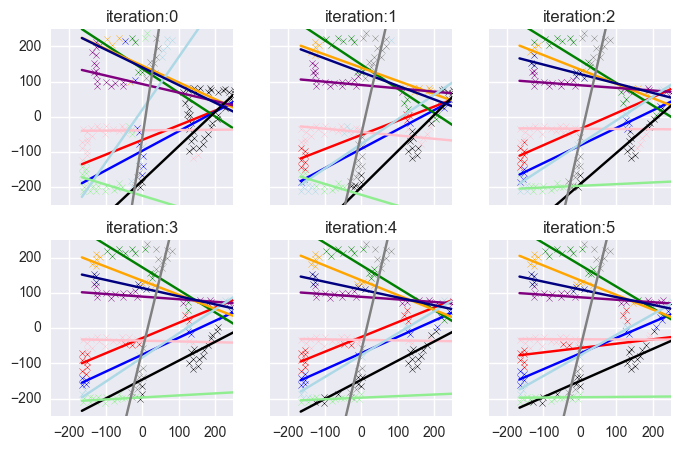

In [505]:
plt.scatter(data[:,0], data[:,1], color='purple', marker='x',
            label='data points')

for n in xrange(N_CLUSTERS):
    
    #plot line
    buff = 0
    xs, ys = getLine(slopes[n], y_inters[n], min_x = np.min(data[:,0])-buff, max_x =np.max(data[:,0]+buff))
    plt.plot(xs, ys,c=colors[n])
    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([MIN_DIM,MAX_DIM])
plt.xlim([MIN_DIM,MAX_DIM])
plt.show()

x = -1
l = -1
plt.rcParams['figure.figsize'] = 8, 5
fig, ax = plt.subplots(2,3, sharex = True, sharey = True)

plt.subplots_adjust( wspace = .2, hspace = .2)
for i in xrange(6):
    c_w = Expectation(covs, mws)
    new_mws, cluster_points = Maximization(c_w) 
    
  
    if i % 1 == 0:
        l+=1
        y = l % 3
        if y == 0:
            x+=1
        plot_it(ax, c_w, x, y, data, slopes, y_inters,"iteration:"+str(i))
        
        

fig.show()

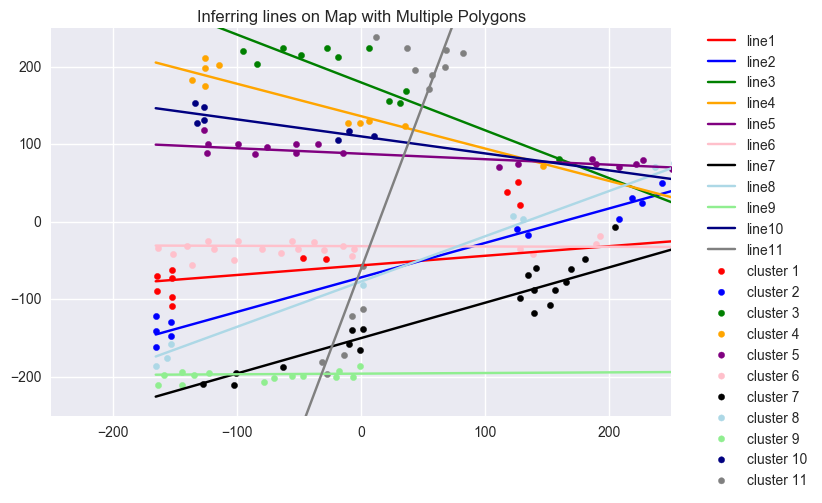

In [507]:
clusters = []
for n in xrange(N_CLUSTERS):
    clusters.append( getPointsInCluster(c_w[:,n:n+1]))
    buff = 0
    xs, ys = getLine(slopes[n], y_inters[n], min_x = np.min(data[:,0])-buff, max_x =np.max(data[:,0]+buff))
    plt.plot(xs, ys, color=colors[n], label="line" + str(n+1))
    
    if len(clusters[n]) > 0:
        plt.scatter(clusters[n][:,0], clusters[n][:,1], color=colors[n],marker='o',
                label='cluster ' + str(n + 1))


plt.ylim([MIN_DIM,MAX_DIM])
plt.xlim([MIN_DIM,MAX_DIM])
plt.title("Inferring lines on Map with Multiple Polygons")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [48]:
# with open("points_per_polygon.dat", "wb") as f:
#     pickle.dump(clusters, f)

In [ ]:
# with open("points_per_polygon.dat") as f:
#     data = pickle.load(f)
    


100%|██████████| 60/60 [00:02<00:00, 25.72it/s]


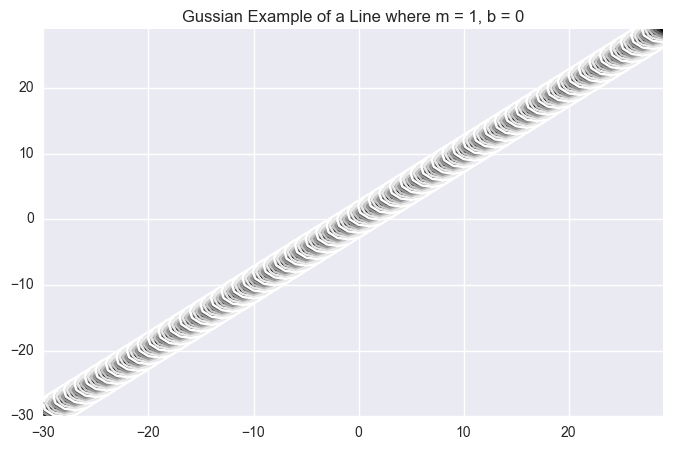

In [103]:
x, y = np.mgrid[-30:30:1, -30:30:1]
m = 1
b = 0
#getLineMu(pt, m, b)
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

for i in tqdm(xrange(-30,30,1)):
    rv = multivariate_normal([i,i], COV_2D)
    plt.contour(x, y, rv.pdf(pos))

# xs, ys = getLine(m, b)
# plt.plot(xs, ys, color = "purple")
plt.title("Gussian Example of a Line where m = 1, b = 0")
plt.show()


In [ ]:
m = 1
b = 0

pt = [100, 50]

xs, ys = getLine(m, b)
plt.plot(xs, ys, "--",color = "grey")

mu = getLineMu(pt, m, b)
plt.ylim([MIN_DIM,MAX_DIM])
plt.xlim([MIN_DIM,MAX_DIM])
plt.scatter(mu[0], mu[1], marker='o', s = 70)
plt.scatter(pt[0], pt[1], color='red', marker='o', s = 70)


plt.title("Datapoint (red) vs Nearest Point on line (blue)")
plt.show()

print mu
#y = gaussian(x, mu, sig)

In [ ]:
def eu_dist(x,y):   
    return np.sqrt(np.sum((x-y)**2))



m = 1
b = 0

pt = [100, 50]

xs, ys = getLine(m, b)
mu = getLineMu(pt, m, b)
print mu,  pt

dist = eu_dist(np.array(pt),np.array(mu))
print dist

output = gaussian(dist, MEAN, COV)
print output

In [ ]:
cluster_n = np.zeros((POINTS,1))


In [ ]:
cluster_n.shape

In [ ]:
cluster_n[0] = 123

In [ ]:
print cluster_n[0]

In [ ]:
all_xs = data[:,0:1]
set_x = np.unique(all_xs)
num_unq_pts =  set_x.shape[0]
set_x = np.reshape(set_x, (num_unq_pts,1))


In [ ]:

line_X = np.arange(-250, 250)
print line_X.shape

In [ ]:
dat = data[:5,:]
print dat.shape
print dat[:,]
wts = np.array([[0.1, 0.5, 0.2, 0.8, 0.1]]).T

def getSkew(data, weights, scaler=20):
    incr = np.rint(weights * scaler)
    skew = []
    for i in xrange(dat.shape[0]):
        for j in xrange(int(incr[i][0])):
            skew.append(dat[i,:])
    skew = np.array(skew)   
    return skew

skew = getSkew(dat, wts)
print skew.shape
print skew[:10,]


In [242]:
random.uniform(-20,20)

-3.7846215361571787

[(-250.0, -166.0), (-166.0, -82.0), (-82.0, 2.0), (2.0, 86.0), (86.0, 170.0), (170.0, 250.0)]
[-193.8538006205523, -160.2457602950592, -23.12853507704918, 13.049287627715572, 140.7764372449907, 243.29489846161562]


In [479]:
-107 - ( -25 * 105)



2518

In [480]:
-107.123 - ( -25.3423 * 105.11232)

2556.664947136